24_25

#  El Problema


Vamos a comenzar por los datos que nos proporciona una competición de DrivenData

[Warm Up: Machine Learning with a Heart](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/)

El conjunto de datos es un clásico del aprendizaje automático. Procede de un estudio de enfermedades cardíacas realizado hace 30 años.

El estudio, convenientemente anonimizado,  recoge varias mediciones sobre la salud de los pacientes y las estadísticas cardiovasculares.


En primer lugar vamos a estudiar el conjunto de entrenamiento (*train_values* y *train_labels*) que facilita la competición y que se puede encontrar en este [link](https://drive.google.com/drive/folders/1NfqnfLQqM-gJu5dh0hAhMURO-7_uDHdK?usp=sharing)

El objetivo es predecir si un paciente tiene o no (clase binaria) una enfermedad cardiaca

Descripción del dataset:

train values:
* slope_of_peak_exercise_st_segment (type: int): the slope of the peak exercise ST segment, an electrocardiography read out indicating quality of blood flow to the heart
* thal (type: categorical): results of thallium stress test measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect
* resting_blood_pressure (type: int): resting blood pressure
* chest_pain_type (type: int): chest pain type (4 values)
* num_major_vessels (type: int): number of major vessels (0-3) colored by flourosopy
* fasting_blood_sugar_gt_120_mg_per_dl (type: binary): fasting blood sugar > 120 mg/dl
* resting_ekg_results (type: int): resting electrocardiographic results (values 0,1,2)
* serum_cholesterol_mg_per_dl (type: int): serum cholestoral in mg/dl
* oldpeak_eq_st_depression (type: float): oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms
* sex (type: binary): 0: female, 1: male
* age (type: int): age in years
* max_heart_rate_achieved (type: int): maximum heart rate achieved (beats per minute)
* exercise_induced_angina (type: binary): exercise-induced chest pain (0: False, 1: True)

train labels:


# Preparación


Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas.

In [279]:
# carga de datos
import pandas as pd
import io
# from google.colab import files  #Como yo uso jupyter notebook, no necesito esta línea
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

df = pd.read_csv('.\\winequality-red.csv', delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Carga de Datos

Los ficheros del dataset a impoortar se encuentran en el CAMPUS:

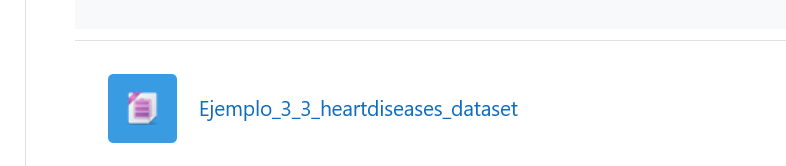


En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [280]:
def upload_files ():  #Nosotros no necesitamos esta función, ya que no vamos a usar google colab
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

## Preparando la evaluación

Para la evaluación vamos a utilizar siempre una matriz de confusión que presentaremos mediante la siguiente función

In [281]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    print("Metrics \n"
      +classification_report(y_true, y_pred))

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

También necesitamos una función para mostrar aquellos modelos seleccionados por los mecanismos de optimización que vamos a utilizar.

# Preproceso

Aquí irían todas las funciones y transformaciones que permitieran el uso de las variables en los siguientes clasificadores, por ejemplo la transformación de las variables categóricas en numéricas, etc.

En este caso no se reailza dicha transformación porque las variables que vamos a utilizar son todas numéricas

In [282]:
selected_features = [] #['resting_blood_pressure', 'serum_cholesterol_mg_per_dl', 'max_heart_rate_achieved'] # Si quisiéramos seleccionar algunas características, lo haríamos aquí

Y para poder hacer el "tuning" de nuestro modelos necesitamos que nuestros datos de entrenamiento estén a su vez divididos entre entrenamiento y test.

* Nota: Faltaría mostrar una matriz de correlación entre las variables para determinar cuáles son las variables que podemos desechar del entrenamiento, en el caso de fuese necesario. Y se modificaría el array **selected_features**

In [283]:
from sklearn.model_selection import train_test_split

# feature selection and transformation
X = df.drop('quality', axis=1)
# X = df[selected_features]

y = df['quality']
# train and test
# Es curioso el analizar los resultados de la calidad de la predicción(accurace), en función del valor
# que asignemos al parámetro test_size
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # El parámetro stratify realiza una división proporcianada
                                                                          # atendiendo a las distintintas clases
#y_train

In [284]:
# Proporción de clases con estratificación
print("\nCon estratificación:")
print("Clases en y_train:", np.bincount(y_train))
print("Clases en y_test:", np.bincount(y_test))


Con estratificación:
Clases en y_train: [  0   0   0   7  37 477 446 139  13]
Clases en y_test: [  0   0   0   3  16 204 192  60   5]


In [285]:
import numpy as np
y_train_array = y_train.to_numpy()
y_train_array
np.bincount(y_train_array)

array([  0,   0,   0,   7,  37, 477, 446, 139,  13])

# Naive Bayes

Dado un ejemplo x representado por k valores, el clasificador Naïve Bayes se basa en encontrar la hipótesis más probable que describa a ese ejemplo. Si la descripción de ese ejemplo viene dada por los valores (a1,…, an), la hipótesis más probable será aquella que cumpla que tenga la mayor probabilidad de que, conocidos los valores que describen a ese ejemplo, éste pertenezca a
la clase vj, donde vj es el valor de la función de clasificación f(x) en el conjunto infinito V.

Podemos estimar P(vj) contando las veces que aparece el ejemplo vj en el conjunto de entrenamiento y dividiéndolo por el número total de ejemplos que forman este conjunto. Para estimar el término P(a1,..., an), es decir, las veces en que para cada categoría aparecen los valores del ejemplo x, se debe
recorrer todo el conjunto de entrenamiento.

Para poder aplicarlos vamos a probar todas las modalidades del mismo que nos ofrece scikit-learn: Gaussian, Multinomial, Bernouilli, Complement.

In [286]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier as knn



# classifiers
names = ["GaussianNB", "MultiNomialNB", 'BernouilliNB', 'ComplementNB', 'KNeighborsClassifier']
classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB(), knn(n_neighbors=5)]

for name, clf in zip(names, classifiers):

  # FIT THE MODEL
  clf.fit(X_train, y_train)
  # PREDIT AND SCORE
  score = clf.score(X_test, y_test) #Returns the mean accuracy on the given test data and labels.
  print ("Modelo: %s = %6.2f" % (name, score))

Modelo: GaussianNB =   0.56
Modelo: MultiNomialNB =   0.41
Modelo: BernouilliNB =   0.42
Modelo: ComplementNB =   0.49
Modelo: KNeighborsClassifier =   0.49


Escogemos al mejor y lo ejecutamos sobre el propio test, luego lo ejecutaremos sobre el test final para generar el fichero de subida a la competición.

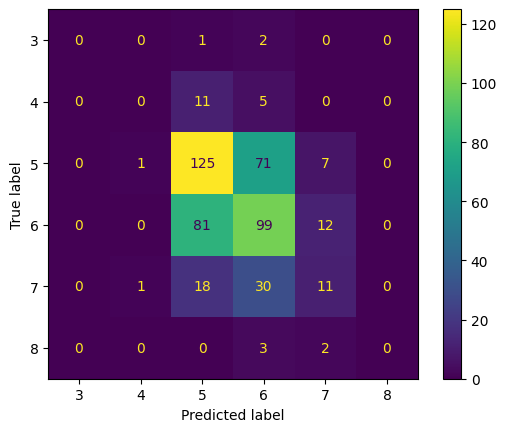

In [287]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = knn()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

labels = unique_labels(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot()

In [288]:
# Este es un test (ejercicio/prueba) para utilizar el método .predict_proba.
# Este método  para obtener las probabilidades de que las observaciones pertenezcan a cada una de las clases.

# En un problema de clasificación binaria, el método predict_proba devolverá un array de dos columnas
# para cada observación en el conjunto de datos de prueba:

# La primera columna contendrá la probabilidad de que la observación pertenezca a la clase 0.
# La segunda columna contendrá la probabilidad de que la observación pertenezca a la clase 1.
# La suma de estas dos probabilidades para una observación específica será siempre igual a 1.
# Estas probabilidades te permiten entender cuán confiado está el modelo en sus predicciones, y
# también te dan la oportunidad de aplicar un umbral de decisión personalizado si no deseas utilizar
# el umbral predeterminado de 0.5 para la clasificación binaria.

# Es curioso, porque el propio manual de scikit-learn dice que esta probabilidad no hay que tomársela demasiado en serio. En fin ¿?¿?
# Título: 1.9. Naive Bayes
# Url: https://scikit-learn.org/stable/modules/naive_bayes.html
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba

array([[0. , 0. , 0. , 0.6, 0.4, 0. ],
       [0. , 0. , 0.2, 0.6, 0.2, 0. ],
       [0. , 0. , 0.6, 0. , 0.4, 0. ],
       ...,
       [0. , 0.2, 0.6, 0.2, 0. , 0. ],
       [0. , 0. , 0.4, 0.6, 0. , 0. ],
       [0. , 0. , 0.6, 0. , 0.2, 0.2]])

In [289]:
# De esta forma podemos definir nosotros el umbral que utilizaremos para decidir finalmente (predecir) si la clase predicha
# es 0 ó 1
umbral = 0.7  # Ejemplo de umbral

# Aplicar el umbral de decisión
# Se asume que la segunda columna corresponde a la clase positiva (clase 1)
predicciones_con_umbral = np.where(y_pred_proba[:, 1] > umbral, 1, 0)

# Mostrar las predicciones con el umbral aplicado
print(predicciones_con_umbral)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


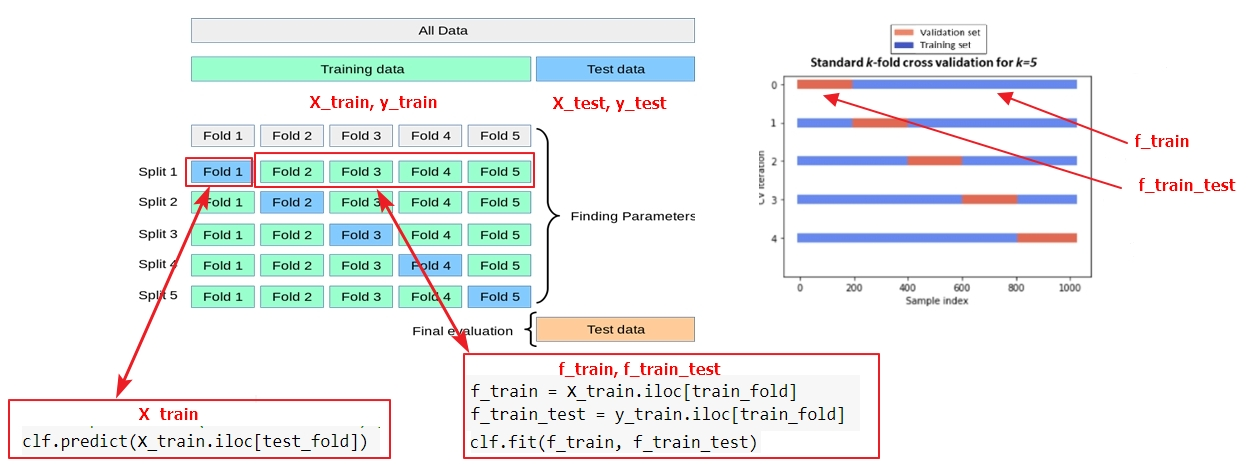

In [290]:
# Añadido por Salvador para comparar la precisión obtenida con el método score, de la celda anterior,
# cuando se utiliza cross validation

from sklearn.model_selection import KFold
cv = KFold(n_splits = 5, shuffle = True) # shuffle = False si hay dimensión temporal
total_scores = []
for name, clf in zip(names, classifiers):
  fold_accuracy = []
  for train_fold, test_fold in cv.split(X_train):
    # División train test aleatoria
    f_train_x = X_train.iloc[train_fold]           # Extrae la información (iloc), atendiendo a los indices obtenidos por CrossValidation
    f_train_y = y_train.iloc[train_fold]
    # entrenamiento y ejeución del modelo
    clf.fit(f_train_x, f_train_y)
    # Realizamos la predicción (Final evaluation) y guardamos la precisión para calcular la media posteriormente
    y_pred = clf.predict(X_train.iloc[test_fold])
    # evaluación del modelo
    acc = accuracy_score(y_train.iloc[test_fold], y_pred)
    fold_accuracy.append(acc)
  total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

for i in range(len(names)):
  print ("Modelo: %s = %6.2f" % (names[i], total_scores[i]))

Modelo: GaussianNB =   0.53
Modelo: MultiNomialNB =   0.44
Modelo: BernouilliNB =   0.42
Modelo: ComplementNB =   0.50
Modelo: KNeighborsClassifier =   0.50


Escogemos al mejor  modelo puntuado y lo ejecutamos sobre el propio train, luego lo ejecutaremos sobre el test final para generar el fichero de subida a la competición.

Accuracy:   0.56


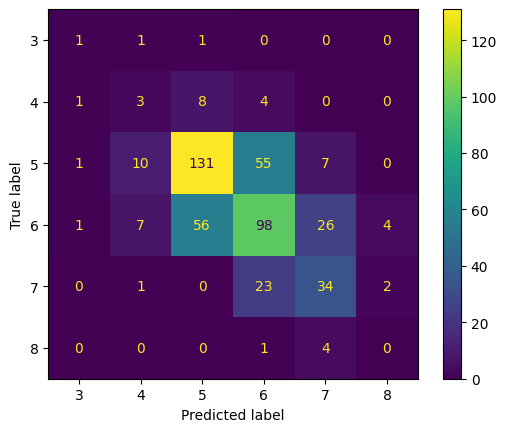

In [291]:
clf = GaussianNB()
#clf = MultinomialNB()
for train_fold, test_fold in cv.split(X_train):
    # División train test aleatoria
    f_train_x = X_train.iloc[train_fold] # Extrae la información (iloc), atendiendo a los indices obtenidos por CrossValidation
    f_train_y = y_train.iloc[train_fold]
    # entrenamiento
    clf.fit(f_train_x, f_train_y)

y_pred = clf.predict(X_test)
# Comparamos lo predicho con lo esperado para los datos de test
acc_GaussianNB = accuracy_score(y_test, y_pred)
print("Accuracy: %6.2f" % acc_GaussianNB)
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot()

In [292]:
from sklearn.model_selection import cross_val_score


# Vamos a entrenar el modelo knn con el conjunto de datos de entrenamiento usando validación cruzada
best_score = 0
best_weights = None
best_N_neighbors= None

for weights in ['uniform', 'distance']:
    for n_neighbors in range(1, 50):
        clf = knn(n_neighbors=n_neighbors, weights=weights)
        clf.fit(X_train, y_train)
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        mean_score = scores.mean()
        # print(f"Weights: {weights}, Mean CV Score: {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_weights = weights
            best_N_neighbors = n_neighbors

print(f"Best Weights: {best_weights}, Best Mean CV Score: {best_score:.4f}, Best n_neighbors: {best_N_neighbors}")

Best Weights: distance, Best Mean CV Score: 0.6273, Best n_neighbors: 34


# Cómo exportar a un fichero el modelo entrenado

In [293]:
# Si tenemos dificultades con la librería joblib la podemos importar
# !pip install joblib

In [294]:
# Para exportar el modelo a un fichero
import sklearn.externals
import joblib
joblib.dump(clf,'Ejemp_3_3_modelo_entrenado.pkl')

['Ejemp_3_3_modelo_entrenado.pkl']

In [295]:
# Para importar el modelo entrenado y ejecutar de nuevo test
clf_entrenado = knn(n_neighbors=n_neighbors, weights=weights)
clf_entrenado = joblib.load('Ejemp_3_3_modelo_entrenado.pkl')
clf_entrenado.score(X_test, y_test) # Obtenemos la precisión
#clf_entrenado.score(X_train, y_train) # Obtenemos la precisión

0.6125

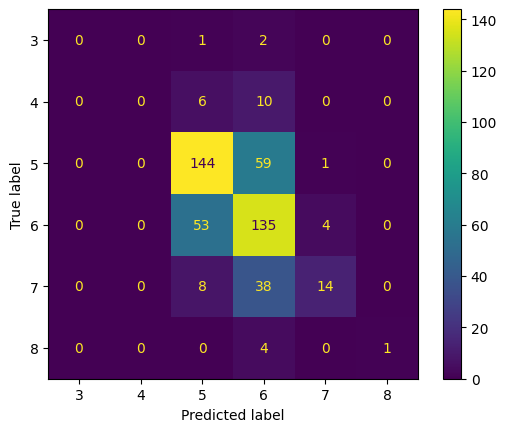

In [296]:
#Volvemos a realizar la validaión final y obtenenmos la matriz de confusión para ver que coincide con la anterior
y_pred = clf_entrenado.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot()

Preparamos un fichero de salida

In [297]:

test = pd.concat([X_test, y_test], axis=1)
res = clf.predict(test.drop('quality', axis=1)) # Recuerda test es el dataFrame que nos ha dejado la competición para
                                           # que nuestro modelo prediga unos resultados. Y son estos resultados los que
                                           # se suben a la web para que nos lo puntúen.
                                           
output = pd.DataFrame({ 'quality': res})
output.head()

,quality
0,6
1,6
2,5
3,7
4,5


Y guardamos el fichero en disco para luego subirlo a la competición (si queremos participar)

In [298]:
# from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)


# files.download('result.csv')